In [1]:
# import required packages
import numpy as np
from sklearn.datasets import load_breast_cancer, fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.svm import SVC, SVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedShuffleSplit, ParameterSampler
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier, HuberRegressor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, mean_squared_error, precision_recall_curve, PrecisionRecallDisplay, RocCurveDisplay, DetCurveDisplay, r2_score
from scipy.stats import ttest_ind, ttest_rel, ttest_1samp
import matplotlib.pyplot as plt  # For creating plots

from ipynb.fs.defs.task3_1 import preprocessStarData, preprocessGWPData
from ipynb.fs.defs.task3_2 import SelectHoldoutSplits, AssessClassification, AssessRegression, findBestParams

In [2]:
# Load pre processed data
star_data = preprocessStarData()
gwp_data = preprocessGWPData()

[array(['GALAXY', 'QSO', 'STAR'], dtype='<U6')]
[array(['Quarter1', 'Quarter2', 'Quarter3', 'Quarter4', 'Quarter5'],
      dtype=object)]
[array(['finishing', 'sweing'], dtype=object)]
[array(['Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday'],
      dtype=object)]


In [3]:
# Check data sets
print(star_data)
print(gwp_data)

[[0.45217391 0.09183086 0.45159189 0.64800655 0.        ]
 [0.83333333 0.11238889 0.8288413  0.89432004 0.        ]
 [0.35144928 0.09316979 0.35094862 0.54396505 0.        ]
 ...
 [0.20362319 0.02183899 0.20340363 0.399645   0.        ]
 [0.52898551 0.06622931 0.52805146 0.64991808 0.        ]
 [0.5826087  0.07874916 0.58171159 0.75040961 0.        ]]
[[1.         0.04763141 0.02722222 0.79733215]
 [0.93150685 0.03925589 0.         0.73618016]
 [1.         0.04157474 0.01388889 0.63927432]
 ...
 [0.79452055 0.03925589 0.         0.44198192]
 [0.93150685 0.02879515 0.         0.30695115]
 [0.8630137  0.04501839 0.         0.18158445]]


Test size: 0.2, Cross-validation score: 0.72899


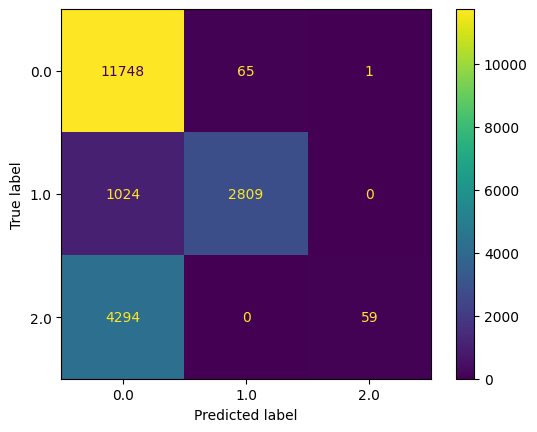

Test size: 0.25, Cross-validation score: 0.73205


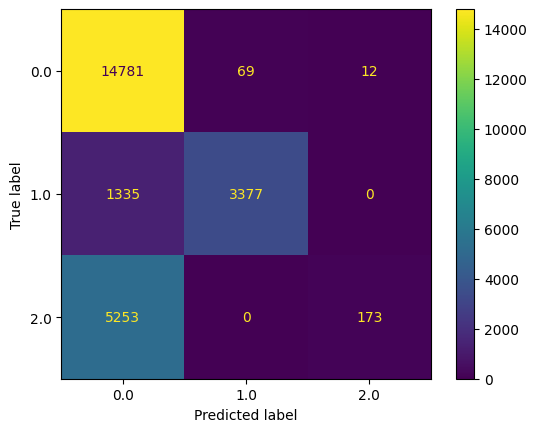

Test size: 0.3, Cross-validation score: 0.72700


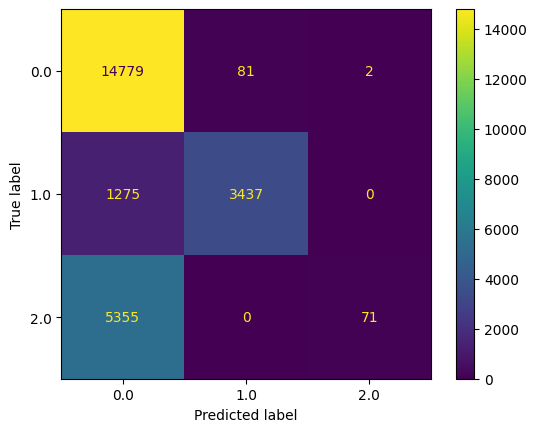

In [4]:
# Find best train, test split
star_x_train, star_x_test, star_y_train, star_y_test = SelectHoldoutSplits(star_data, SGDClassifier(max_iter=2000), 'classification')

# This shows that so far there is a trend where most misclassifications occur with classes, 0 and 2. As overall, the test size 0.3 had the highest accuracy score, this split will be used going forward.

In [5]:
# Loop through and test different loss parameters for SGDClassifier
loss = ['hinge', 'log_loss', 'modified_huber', 'perceptron', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']
for l in loss:
    sgdc = SGDClassifier(loss=l)
    scores = cross_val_score(sgdc, star_x_train, star_y_train, cv=8)
    sgdc.fit(star_x_train, star_y_train)
    y_pred = sgdc.predict(star_x_test)

    print(f"Kernel: {l}, Cross-validation score: {scores.mean():.5f}")
    

Kernel: hinge, Cross-validation score: 0.73141
Kernel: log_loss, Cross-validation score: 0.73220
Kernel: modified_huber, Cross-validation score: 0.86165
Kernel: perceptron, Cross-validation score: 0.84232
Kernel: huber, Cross-validation score: 0.67679
Kernel: epsilon_insensitive, Cross-validation score: 0.69029


C:\Users\itsfl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\itsfl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\itsfl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\itsfl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consid

Kernel: squared_epsilon_insensitive, Cross-validation score: 0.27397


C:\Users\itsfl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [6]:
# Seeing that 'modified_huber' gives the best cross-validation score, this kernel will be used going forward

In [7]:
# Function taking training and test data, model, and parameters specified to generate a list of randomised parameter configurations
# and selecting the best 
def findBestParamsPS(x_train, x_test, y_train, y_test, model, param_grid, clustering=False):
    param_list = list(ParameterSampler(param_grid, n_iter=20, random_state=0))
    
    # Test each parameter configuration randomly sampled from RandomSampler above
    best_score = 0
    best_p_index = 0
    for p in param_list:
        model.set_params(**p)
        scores = cross_val_score(model, x_train, y_train, cv=5)
        
        # Using a different formula for calculating score if the model tested is a clustering model
        if clustering==True:
            model.fit(x_train)
            scores = np.sum(model.predict(x_test) == y_test) / y_test.size

        print(f"Parameters: {param_list.index(p)}, Cross-validation score: {scores.mean():.5f}")

        if scores.mean() > best_score:
            best_score = scores.mean()
            best_p_index = param_list.index(p)
    print(best_p_index)
    return param_list[best_p_index]

In [8]:
# Use ParameterSampler to form set of parameter configurations and test them manually 
params_sgdc = {'loss': ['modified_huber'],
         'penalty': ['l2', 'l1', 'elasticnet', None],
         'tol': [0.0001, 0.001, 0.00001],
         'epsilon': [0.1, 1, 10, 100, 1000],
         'fit_intercept': [True, False],
         'verbose': [False],
         'eta0': [0.1, 1, 10, 100, 1000],
         'early_stopping': [True, False],
         'warm_start': [True, False]}
sgdc = SGDClassifier(**findBestParamsPS(star_x_train, star_x_test, star_y_train, star_y_test, SGDClassifier(), params_sgdc))

Parameters: 0, Cross-validation score: 0.94448
Parameters: 1, Cross-validation score: 0.94748
Parameters: 2, Cross-validation score: 0.91203
Parameters: 3, Cross-validation score: 0.84548
Parameters: 4, Cross-validation score: 0.86200
Parameters: 5, Cross-validation score: 0.82921
Parameters: 6, Cross-validation score: 0.85659
Parameters: 7, Cross-validation score: 0.86505
Parameters: 8, Cross-validation score: 0.94648
Parameters: 9, Cross-validation score: 0.90852
Parameters: 10, Cross-validation score: 0.94597
Parameters: 11, Cross-validation score: 0.87159
Parameters: 12, Cross-validation score: 0.94711
Parameters: 13, Cross-validation score: 0.94713
Parameters: 14, Cross-validation score: 0.94684
Parameters: 15, Cross-validation score: 0.94719
Parameters: 16, Cross-validation score: 0.85944
Parameters: 17, Cross-validation score: 0.84369
Parameters: 18, Cross-validation score: 0.90977
Parameters: 19, Cross-validation score: 0.91260
1


# It is clear that there is quite a range of how performance is affected by the hyper parameters, there is a significant performance as a result of some hyper parameters, much more than what was seen in the MLPClassifier.


Accuracy Score: 0.94596


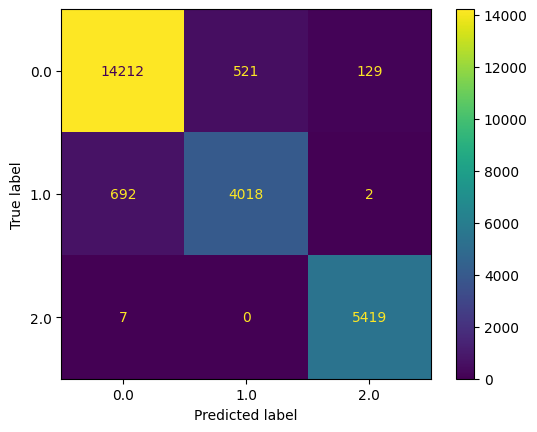

Precision Score: 0.94596
Recall Score: 0.94596


In [9]:
# Display visualisations and accuracy scores to assess performance of model generated from hyperparameterisation
AssessClassification(star_x_train, star_x_test, star_y_train, star_y_test, sgdc)

# Generally the distribution of classifications from this model show that misclassifications occur much more frequently with class 0, which may be due in part to the fact that an overwhelming majority of classes are of type 0.

In [10]:
# Find best train, test split
gwp_x_train, gwp_x_test, gwp_y_train, gwp_y_test = SelectHoldoutSplits(gwp_data, HuberRegressor(), 'regression')

Test size: 0.2, Cross-validation score: 0.14964
MSE: 0.0319470989608731, RMSE: 0.17873751413979413
Test size: 0.25, Cross-validation score: 0.10219
MSE: 0.02997883416170619, RMSE: 0.17314396946387187
Test size: 0.3, Cross-validation score: 0.11564
MSE: 0.02984217762071689, RMSE: 0.17274888601874366


In [11]:
# Use ParameterSampler to form set of parameter configurations and test them manually 
params_hr = {'epsilon': [1, 10, 100],
         'alpha': [0.0001, 0.00001, 0.000001],
         'tol': [0.0001, 0.001, 0.00001],
         'fit_intercept': [True, False]}

hr = HuberRegressor(**findBestParamsPS(gwp_x_train, gwp_x_test, gwp_y_train, gwp_y_test, HuberRegressor(), params_hr))

Parameters: 0, Cross-validation score: 0.15138
Parameters: 1, Cross-validation score: 0.15138
Parameters: 2, Cross-validation score: 0.14749
Parameters: 3, Cross-validation score: 0.14748
Parameters: 4, Cross-validation score: 0.15138
Parameters: 5, Cross-validation score: 0.15563
Parameters: 6, Cross-validation score: 0.14749
Parameters: 7, Cross-validation score: 0.14748
Parameters: 8, Cross-validation score: 0.15137
Parameters: 9, Cross-validation score: 0.14749
Parameters: 10, Cross-validation score: 0.17374
Parameters: 11, Cross-validation score: 0.15138
Parameters: 12, Cross-validation score: 0.15137
Parameters: 13, Cross-validation score: 0.17391
Parameters: 14, Cross-validation score: 0.14749
Parameters: 15, Cross-validation score: 0.15548
Parameters: 16, Cross-validation score: 0.15548
Parameters: 17, Cross-validation score: 0.14749
Parameters: 18, Cross-validation score: 0.14749
Parameters: 19, Cross-validation score: 0.15137
13


# Here there is also an increase in performance as a result of the hyper parameters incorporated into the model, although there is not as much of a range as for the classification model. The increase may not be as substantial either as the gwp dataset is vastly smaller than the star dataset.

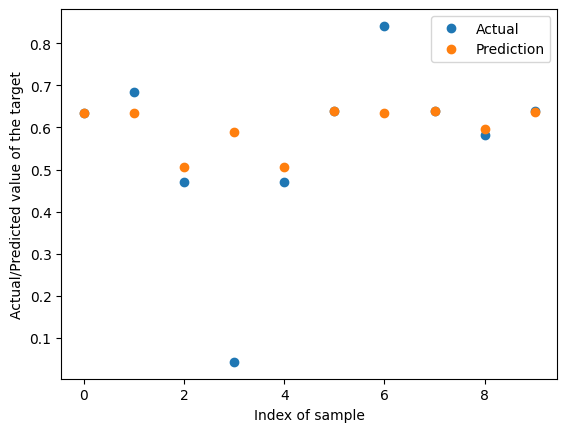

Accuracy Score: 0.18102193958606005
Cross-Validation Score: -1.6973473345563148
MSE: 0.03150317302205572
RMSE: 0.17749133224486124
Mean squared error: 0.03
Coefficient of determination: 0.18


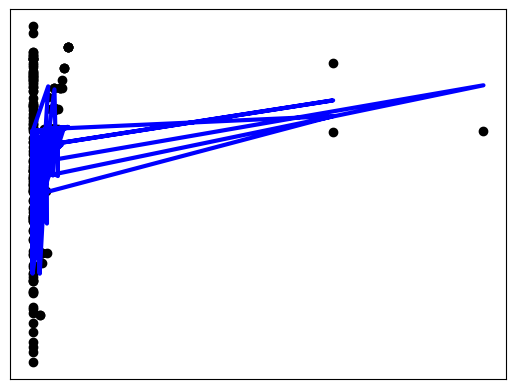

In [12]:
# Display visualisations and accuracy scores to assess performance of model
AssessRegression(gwp_data, gwp_x_train, gwp_x_test, gwp_y_train, gwp_y_test, hr)

# The graph displays that although there are mostly predictions far off the actual value, there are still some predictions which come close or are accurate.

# Similarly, to the SVR model, there is an outlier coefficient value which can be negatively affecting the model's capabilities of predicting accurately. 

In [13]:
params = {'activation': ['relu', 'tanh', 'logistic'],
              'batch_size': [320, 640, 1280],
              'shuffle': [True, False],
              'tol': [0.0001, 0.001, 0.00001],
              'alpha': [0.00001, 0.0001, 0.001, 0.01]}

mlp = MLPClassifier(solver='adam', hidden_layer_sizes=(100,), **findBestParams(star_x_train, star_y_train, MLPClassifier(), params))

{'tol': 1e-05, 'shuffle': False, 'batch_size': 320, 'alpha': 1e-05, 'activation': 'relu'}


C:\Users\itsfl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [14]:
params_reg = {'kernel': ['poly'],
         'degree': [3, 6, 9],
         'gamma': ['auto', 'scale'],
         'tol': [0.0001, 0.001, 0.01],
         'C': [1, 10, 100, 1000],
         'epsilon': [0.01, 0.1, 0.2],
         'shrinking': [True, False],
         'verbose': [False]}

svr = SVR(**findBestParams(gwp_x_train, gwp_y_train, SVR(), params_reg))

{'verbose': False, 'tol': 0.001, 'shrinking': True, 'kernel': 'poly', 'gamma': 'auto', 'epsilon': 0.1, 'degree': 6, 'C': 10}


In [15]:
score_sgdclassifier = cross_val_score(sgdc, star_data[:, :-1], star_data[:, -1])
score_mlp = cross_val_score(mlp, star_data[:, :-1], star_data[:, -1])
print(score_mlp, score_sgdclassifier)

C:\Users\itsfl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\itsfl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\itsfl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\itsfl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

[0.94875 0.94635 0.9513  0.95035 0.94885] [0.9369  0.9326  0.94565 0.91365 0.94165]


C:\Users\itsfl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [16]:
ttest_rel(score_mlp, score_sgdclassifier)

TtestResult(statistic=2.676613302023778, pvalue=0.05542335924928972, df=4)

In [17]:
score_hr = cross_val_score(hr, gwp_data[:, :-1], gwp_data[:, -1])
score_svr = cross_val_score(svr, gwp_data[:, :-1], gwp_data[:, -1])
print(score_hr, score_svr)

[ 1.58673375e-01  1.13994200e-01  2.52362882e-01  6.40778425e-03
 -7.03388917e+00] [ 0.19696465  0.03159517  0.19312761 -0.00559084  0.16489829]


In [18]:
ttest_rel(score_hr, score_svr)

TtestResult(statistic=-0.979951315656732, pvalue=0.3825948780208278, df=4)

# For both datasets the null hypothesis was rejected as the pvalue for both tests are very low. This can be seen above as the pvalue for the models compared for the star dataset is 0.0137 rounded to three significant figures and the pvalue for the models compared for the gwp dataset is 0.374. Although the gwp dataset has a much higher value than the star dataset, it still is sufficiently low enough to mean that there is enough evidence to suggest that the models perform differently so the null hypothesis can be safely rejected.